<a href="https://colab.research.google.com/github/ThomasGesseyJones/DARA_21cm_Signal_Simulation/blob/main/DARA_21cm_Signal_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DARA 21-cm Signal Simulation


In this notebook we'll create a simple simulation of the 21-cm signal together. We shall impliment the key physics we learnt in the theory lectures earlier and produce our own predictions for what the 21-cm global signal and power spectrum may look like.

If you haven't already it found it there this notebook is hosted on GitHub at
[https://github.com/ThomasGesseyJones/DARA_21cm_Signal_Simulation](https://github.com/ThomasGesseyJones/DARA_21cm_Signal_Simulation)

This repository also provides a short README.md on how to get your own copy of this notebook on your google account so you can follow along and experiment!

## Types of 21-cm Signal Simulation

Before we start we need to decide what type of 21-cm signal simulation we are going to create. Broadly speaking we can split 21-cm signal simulations into three categories:
- Analytic (e.g.)
- Full-numerical (e.g. )
- Semi-numerical (e.g. )

**Analytic** simulations typically operate by solving the differential equations that describe the 21-cm signal's evolution under the assumption of a homogeneous universe. So they treat the 21-cm signal $T_{\rm 21}$ at a given redshift $z$ and all things it depends upon, such as the kinetic temperature $T_{\rm K}$ and electron fraction $x_{\rm e}$, as homogeneous throughout the entire universe. This has the advantage that for each of theese quantities at each redshift step you only need to store one number, and so it requires very little memory. In addition, because radiative transfer does not need to be modelled solving the differential equaitons is computaitonally easy, leading to very quick codes. Unfortunatley, the 21-cm signal is not uniform and assuming so means you cannot make predictions for the 21-cm power spectrum, and your predicitons of the global 21-cm signal are biased (#TODO ciation). 

**Full-numerical** simulations using particle-hydrodynamics codes to model the evolution of large portions of the universe. Physics often modelled includes, dark matter and baryons collapsing into halos under gravity, chemical and thermal evolution of the gas, star formation, and radiative transfer. As star formation occurs on much smaller scales (parsecs) than the cosmological volumes of interest (Megaparsecs or Gigaparsecs) these simulations require billions of particles to get sufficient resolution. Consequently, they are hugely computationally expensive. For example the CODA3 recently ran on the XX supercomputer taking... (#TODO citations). 

**Semi-numerical** simulations are somewhat of a compromise between the previous two. They aim to be physically realistic enougth to produce accurate predictions of the 21-cm signal, including its spatial variations, but fast and low-memory enougth to be run on a commerically available desktop computer. This is typically achieved by splitting the cosmological volume into simulation cells. Each cell can have a different temperature, ionization fraction, 21-cm signal, etc..., and hence allows for the variation in the signal to be modelled. Physics below the size of the cell, e.g. star formation, is not numerically modelled but instead treated using analytic approximations, while large scale physics that goes between cells, e.g. radiative transfer, is treated numerically. Hence, the name semi-numerical. 

Since, we want accurate enougth predictions in a reasonable time frame (ideally the hour length of this session) we shall develop a simple semi-numerical simulation code. 

##Representing the Universe

As mentioned above we are going to split our simulation of the universe into $N \times N \times N$ pixels each with some sidelength $L_{\rm pix}$. Prior wisdom shows $L_{\rm pix} = 3$ comoving Megaparsecs is a good choice for the latter value. In case, you haven't seen it before comoving lengths are distances that scale with the expansion of the universe. So 3 comoving Megaparsecs means the pixel would be 3 Megaparsecs large today, but it would have been 1.5 Megaparsecs in physical size at redshift $1$, when the universe was half its current size, and only 0.06 Megaparsecs at redshift $49$. We choose to have our cells be defined in comoving Megaparsecs so they, and our simulation box, scales automatically with the expansion of the universe. 

Note, so that our simulation does not depend on things outside of our simulation box we shall be using periodic boundary conditions throughout. 

Let us start then by defining these all important quantities as constants for our simulation

In [1]:
L_PIX = 3   # Pixel size in cMpc
N_PIX = 128  # Number of pixels on each side of the simulation cube (kept small so runtime short)

Now we have the space of our simualation sorted, let us think about the time variable. Time is a pain to work with in cosmology in general because its specific to the exact cosmological parameters you are using, and isn't a direct observable. Instead its more common to work in redshift $z$. Hence that is what we shall do to. For simplicity we shall hardcode our simulation to run from redshift $50$ to $6$ (roughly the end of reionization when $T_{\rm 21}$ vanishes) in steps of size 1

In [2]:
import numpy as np
ZS_SIM = np.arange(50, 5, -1)  # Redshift time-steps of our simulation
print(ZS_SIM)

[50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27
 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6]


## Algorithm Overview

Before we go any further let us think about our end goal so we can keep it in mind as we code. We wish to compute the 21-cm signal $T_{\rm 21}$. As we establihsed in the theory lecture earlier to do this we need to know the
- Background radiation temperature $T_{\gamma}$
- IGM kinetic temperature $T_{\rm K}$
- Neutral fraction of the IGM $x_{\rm HI}$ or equivalently the electron fraction $x_{\rm e}$
- IGM hydrogen density $n_{\rm H}$
- Lyman-$\alpha$ intensity $J_{\rm \alpha}$, so that we can calculate the coupling of $T_{\rm S}$ to $T_{\rm K}$

In our simulations we shall not include any excess radio background, and so we can take $T_{\gamma}$ to just be the CMB temperature

In [3]:
T_CMB_0 = 2.725  # K
def temperature_background_radiation(redshift):
    """ Calculates T_gamma at a given redshift """
    return T_CMB_0 * (1 + redshift)

The other four quantities vary between different locations in our simulations. Hence, we shall need to model the evolution of these numerically, finding at each redshift $N \times N \times N$ cubes of $T_{\rm K}$, $x_{\rm HI}$, $n_{\rm H}$, and $J_{\alpha}$. There are a few possible ways we could set-up the numerical loop, experience tells us a reliable method is starting from some initial conditions at each redshift step we should:
1. Use perturbation theory to evolve the overdensity to the current $z$ and thus find $n_{\rm H}$
2. Use an analytic prescription to calculate star formation rates given the current overdensity in a cell
3. Using star formation rate find the radiation fields at the current time step (for our simple simulation these are the Lyman-$\alpha$, Ionizing photon, and X-ray)
4. Numerically integrate $T_{\rm K}$ to the current redshift
5. Numerically integrate $x_{\rm e}$ to the current redshift
6. Repeat for the next redshift 

But before we impliment these 6 steps, we need somewhere to start from, the initial conditions. 

## 0. Initial Conditions

Now let us specify the initial state of the simulation at $z = 50$. Many excellent codes exist (CAMB, CLASS, RECFAST) to evolve analytically from the CMB at redshift $z \approx 1100$ down to $z = 50$, and so we shall use the outputs of these codes to set our simulations initial state


In [4]:
initial_tk = np.ones((N_PIX, N_PIX, N_PIX), dtype=float) * 72    # z = 50, kinetic temperature 72 K (from RECFAST) assumed uniform
initial_xe = np.ones((N_PIX, N_PIX, N_PIX), dtype=float) * 5e-4  # xe = 5e-4, electron fraction 0.0005 (from RECFAST) assumed uniform

For $T_{\rm K}$ and $x_{\rm e}$ we assumed them to be uniform, simplifying our setting of initial conditions. However, if we set all the initial state of our simulation to be uniform then our simulation being deterministic will produce a uniform $T_{\rm 21}$ signal which we know is not realistic. It turns out the key spatial variation to encompass is that in density, normally expressed in terms of overdensity $\delta$, the fractional increase in density. At $z = 50$ the matter overdensity at our simulation lengthscales is expected to be described by a Gaussian random field, with a power spectrum that we can compute with boltzmann solver codes such as CAMB. Here we us a fitting formula to the 
that power spectrum for quicker evaulation. 




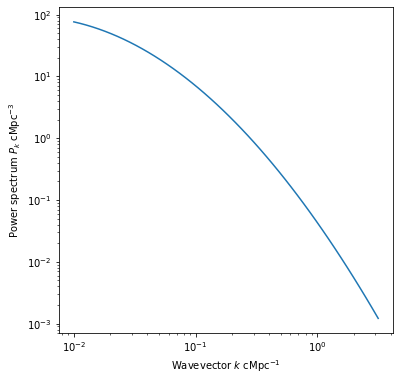

In [5]:
# Spherical power spectrum approximation
def overdensity_spherical_power_spectrum(comoving_wavevector):
    """ 
    Approximation of matter overdensity spherically averaged power spectrum at
    z = 50. Only valid for 0.03 cMpc^-1 <= k <= 1.8 cMpc^-1. 
    
    Returns power spectrum in units of cMpc^3 at given k.
    """
    log_ks = np.log(comoving_wavevector)   # Assume comoving wavevector in inverse cMpc
    polynomial_fit = -0.2562 * log_ks**2 + -2.8043 * log_ks + -3.1453
    return np.exp(polynomial_fit)


# Visualize 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 6))
plotting_ks = np.logspace(-2, .5)
ax.plot(plotting_ks, overdensity_spherical_power_spectrum(plotting_ks))
ax.set_xlabel('Wavevector $k$ cMpc$^{-1}$')
ax.set_ylabel('Power spectrum $P_k$ cMpc$^{-3}$')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()
plt.close(fig)

We thus want to find a gaussian random field with the above power spectrum. The computational details of how to do this is not important for us, all we need is the end product, the cube of overdensities at redshift 50, depicted below. 

<ipython-input-5-36b6464dbc8f>:9: RuntimeWarning: divide by zero encountered in log
  log_ks = np.log(comoving_wavevector)   # Assume comoving wavevector in inverse cMpc
<ipython-input-5-36b6464dbc8f>:10: RuntimeWarning: invalid value encountered in add
  polynomial_fit = -0.2562 * log_ks**2 + -2.8043 * log_ks + -3.1453


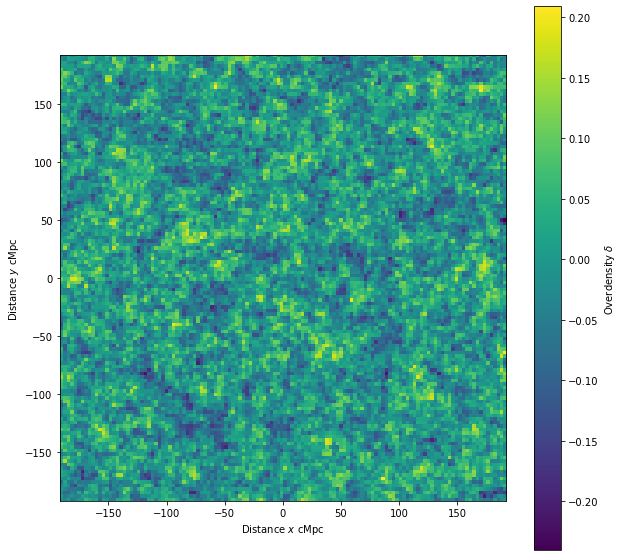

In [6]:
import scipy.fft
import scipy.fftpack

# Function to compute gaussian random field
def compute_gaussian_random_field(size, spherical_power_spectrum_fn):
    """ Function to compute a gaussian random field """

    # Start with a normal gaussian random field and convert to fourier space
    # this is to enforce P(k) = *P(-k) property so we get a real field on
    # ifftn 
    standard_gaussian_random_field = np.random.normal(0, 1, size)
    field_in_k_space = scipy.fft.fftn(standard_gaussian_random_field)

    """ Each fourier mode now is a gaussian random variable with expected 
    square magnitude = N_PIX**3. Hence, it needs to be scaled
    so its expected square magnitude is the power spectrum value """

    # Find wavevectors for each point in our random field
    ks_1d = [2*np.pi*scipy.fftpack.fftfreq(N_DIM, d=L_PIX) for N_DIM in size]
    kxs, kys, kzs = np.meshgrid(*ks_1d)
    ks = np.sqrt(kxs**2 + kys**2 + kzs**2)

    # Corresponding power spectrum and thus normalization
    spherical_pk_at_ks = spherical_power_spectrum_fn(ks)
    normalizations = np.sqrt(spherical_pk_at_ks/L_PIX**3)
    normalizations[0, 0, 0] = 0  # Special case, = 0 by overdensity definition  

    # Scale and return field back in real-space
    scaled_field = field_in_k_space*normalizations
    return np.real(scipy.fft.ifftn(scaled_field))


# Fix random seed for reproducability 
import random
random.seed(102023)

# Get our overdensity field 
overdensity_z_50 = compute_gaussian_random_field((N_PIX, N_PIX, N_PIX), overdensity_spherical_power_spectrum)


# Depict a slice of the overdensity
fig, ax = plt.subplots(figsize=(10, 10))
image = ax.imshow(overdensity_z_50[:, :, 0], cmap='viridis', extent=[-N_PIX*L_PIX/2, N_PIX*L_PIX/2, -N_PIX*L_PIX/2, 
                                                                     N_PIX*L_PIX/2])
cbar = fig.colorbar(image, ax=ax, label='Overdensity $\delta$')

ax.set_xlabel('Distance $x$ cMpc')
ax.set_ylabel('Distance $y$ cMpc')

plt.show()
plt.close(fig)

Throughout our simulation we are going to want to store a couple of things as we go so let us define data structures to contain these. They are the 21-cm signal, our end results, and the star formation rate density, which we need for all past redshifts to compute the radiation field at the current redshift. 

In [7]:
t21_cubes = np.empty((N_PIX, N_PIX, N_PIX, len(ZS_SIM)), dtype=float)    # 21-cm signal in mK
sfrd_cubes = np.empty((N_PIX, N_PIX, N_PIX, len(ZS_SIM)), dtype=float)   # SFRD in Msol per yr per cMpc^3

We should also give these initial conditions. Since we do not know what the 21-cm signal is at redshift 50, let us be safe and just give it the value NaN. While for the SFRD, we are fairly confident their is no star formation rate yet and so can set it to zero

In [8]:
t21_cubes[:, :, :, 0] = np.nan
sfrd_cubes[:, :, :, 0] = 0

## 1. Evolving Overdensity

We now have our initial conditions all set. So we shall now work through our simulation loop, defining functions that will perform those key-steps for us. The first on our list is to evolve the overdensity $\delta$ to the current redshift, and thus find $n_{\rm H}$. As we are considering large scales at high redshifts we shall assume we can treat the overdensity as always evolving via linear perturbation theory (this assumption breaks down for rare peaks and troughs at low redshifts in our simulation). Linear perturbation theory predicts the overdensity grows as $\propto 1/(1+z)$, so we can impliment this step quite simply. 


In [9]:
def current_overdensity_field(redshift):
    """ Calculates current overdensity """
    # Linear perturbation theory growth
    current_overdensity = overdensity_z_50 * (1 + np.max(ZS_SIM)) / (1 + redshift)

    # Ad hoc fix to stop it going into unphysical regions in rare peaks (above critical overdensity)
    current_overdensity = np.minimum(current_overdensity, 1.686*(1-(1+redshift)/2000))  
    # or rare voids (below -1)
    current_overdensity = np.maximum(current_overdensity, -1)

    return overdensity_z_50

To convert this to the hydrogen number density $n_{\rm H}$ in each pixel, we then times by the average comoving hydrogen number density (a constant post recombination), abd adjust for the dilation of space to get a physical density

In [10]:
def physical_nh(redshift):
    """ Calculates the hydrogen number density at a given redshift """
    # Get comoving number density
    average_comoving_nh = 5.5899e+66          # From Planck in particles per comoving megaparsec 
    comoving_nh = average_comoving_nh*current_overdensity_field(redshift)

    # Correct into physical density
    return comoving_nh * (1 + redshift)**3

## 2. Star Formation Prescription 

Now we know the overdensity in each cell at a given redshift we need to convert this into star formation. We shall do this in three stages. First using an analytic prescription we shall find the expected number of dark matter halos of different masses in a pixel with a given overdensity. Then we use an analytic prescription to decide which halos will form stars. Finally we shall convert the total dark matter halo mass to a stellar mass using a star formation efficiency. 

For our analytic prescription for the expected number of dark matter halos we shall used the standard Sheth-Tormen mass function. Thankfully, this is a very commonly used function and so there already exists python packages that impliment this function for us, such as `hmf`

In [11]:
!pip install hmf
import hmf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 KB 796.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 2.7 MB/s eta 0:00:00
  Created wheel for camb: filename=camb-1.3.6-py3-none-any.whl size=1063328 sha256=df985ac789d732752be2061eac363e40ee7df8bc24f97febed93cf2a1749230c
  Stored in directory: /root/.cache/pip/wheels/bd/67/8c/7ccb547de7a94170c67cc3294f520e48451d1947bb26572bce
Successfully built camb


This package impliments various mass functions via the MassFunction object. To get the mass function at a particular redshift, over a desired mass range, we simply instantiate such an object with the appropriate redshift `z`, minimum halo mass `Mmin` and maximum halo mass `Mmax`. Then access the halo mass function as properties of the object. 

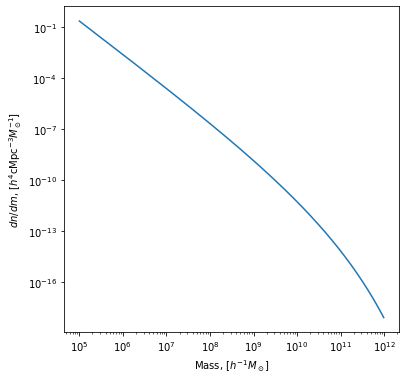

In [34]:
# Instansiate halo mass function 
mf = hmf.MassFunction(z=7, Mmin=5, Mmax=12)

# Depict halo mass function 
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(mf.m, mf.dndm)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"Mass, $[h^{-1}M_\odot]$")
ax.set_ylabel(r"$dn/dm$, $[h^{4}{\rm cMpc}^{-3}M_\odot^{-1}]$")
plt.show()
plt.close(fig)

We can account for being in an overdense or underdense region by increasing or decreasing the sigma_8 parameter of the mass function 

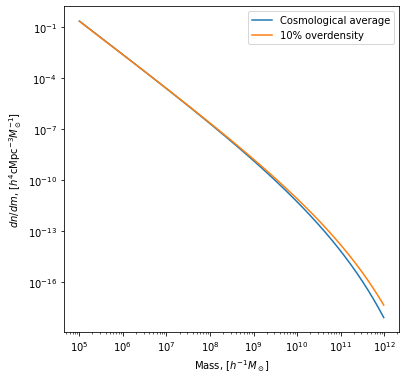

In [35]:
# Save old results
mf_m = mf.m
mf_dndm = mf.dndm

# Get sigma 8 from Planck LCDM cosmology 
cosmological_sigma_8 = hmf.MassFunction.get_all_parameter_defaults(recursive=False)['sigma_8']

# Increase sigma 8 to simulate being in a 10% overdensity 
example_overdensity = 0.1
overdense_mf = hmf.MassFunction(z=7, Mmin=5, Mmax=12, sigma_8=cosmological_sigma_8*(1 + example_overdensity))

# Plot comparison 
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(mf_m, mf_dndm, label='Cosmological average')
ax.plot(overdense_mf.m, overdense_mf.dndm, label='10% overdensity')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"Mass, $[h^{-1}M_\odot]$")
ax.set_ylabel(r"$dn/dm$, $[h^{4}{\rm cMpc}^{-3}M_\odot^{-1}]$")
ax.legend()
plt.show()
plt.close(fig)

As a word of caution `hmf` uses hubble normalized physical units, which we will need to correct for as we are using unscaled comoving units. 

On too the second step then. What halos form stars? Again we shall use a simple analytic prescription that does not include any feedback effects, in this case that of Tegmark et al. 1997 (TODO). That halos form stars if they are above
$$
M_{\rm crit} = \left(3.3 \times 10^7 {\rm \,M}_{\odot}\right) \times (1 + z)^{-3/2}
$$


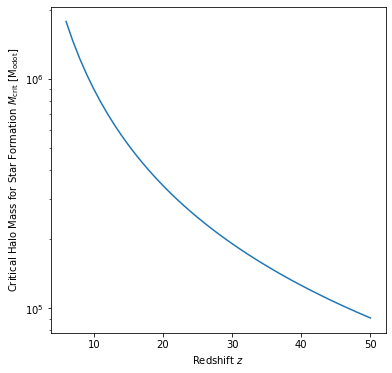

In [36]:
def critical_halo_mass_for_star_formation(redshift):
    """ Dark matter halo mass above which stars will form in the halo """
    return 3.3e7 * ((1 + redshift)**(-3/2))


# Illusration of this function 
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(ZS_SIM, critical_halo_mass_for_star_formation(ZS_SIM))
ax.set_yscale('log')
ax.set_xlabel(r"Redshift $z$")
ax.set_ylabel(r"Critical Halo Mass for Star Formation $M_{\rm crit}$ [M$_{\rm odot}$]")
plt.show()
plt.close(fig)

Finally we need to specify our star formation efficiency. We can split this into two efficiency factors, the fraction of a halos mass that is baryons $f_{\rm g}$ and the fraction of baryons which are in stars $f_{*}$. For the former we shall just assume the cosmological ratio holds for halos as well and use

In [15]:
F_GAS = 0.171

While we shall take $f_*$ as a simulation parameter and hence leave it as an input. 

Let us now combine all of this into a function that compute the star formation rate densities at a given redshift

In [40]:
# Scipy functions we will need
from scipy.interpolate import interp1d
from scipy.integrate import trapz 

# Cosmological parameter we will need
PLANCK_h = 67.4/100
PLANCK_Omega_m = 0.315


# First get stellar mass in each cell
def stellar_mass(redshift, f_star):
    """ Get stellar mass density in each cell in Msol cMpc^-3 """
    
    # Current overdensity
    overdensity = current_overdensity_field(redshift)

    # Current critical mass for star formation
    m_crit = critical_halo_mass_for_star_formation(redshift)

    # For efficiency let us define an interpolator function to approximate the stellar mass integral
    # Start by setting what values we are going to interpolate in between
    sample_overdensities = np.linspace(np.min(overdensity), np.max(overdensity), 100)
    sample_solar_mass_densities = np.empty(sample_overdensities.shape, dtype=float)

    # Get the mass function at this redshift above the critical mass threshold
    create_mass_function = hmf.MassFunction(z=redshift, Mmin=np.log10(m_crit/PLANCK_h), Mmax=np.log10(1e13/PLANCK_h))

    # Update the mass thershold for each overdensity (updating is more efficient as can reuse parts of calculation)
    for idx, delta in enumerate(sample_overdensities):
        create_mass_function.update(sigma_8=cosmological_sigma_8*(1 + delta))

        # Correct for hubble normalized units being used
        halo_masses = create_mass_function.m / PLANCK_h
        halo_mass_function = create_mass_function.dndm * PLANCK_h**4

        # Integrate to find stellar mass density in Msol cMpc^-3 (performed in ln M for accuracy)
        stellar_mass_density = trapz(f_star*F_GAS*(halo_masses**2)*halo_mass_function, np.log(halo_masses))

        # Store correcting for comoving volume 
        sample_solar_mass_densities[idx] = stellar_mass_density
    
    # Setup the interpolator
    delta_to_solar_mass_fn = interp1d(sample_overdensities, sample_solar_mass_densities)

    # Interpolate to get out density cube
    return delta_to_solar_mass_fn(overdensity)


# Convert to star formation rate
def star_formation_rate_density(redshift, f_star):
    """ Get star formation rate density cube in Msol yr^-1 cMpc^-3 """

    # Find change in stellar mass between now and a short time (dz) ago
    dz = 1e-5
    stellar_mass_density_now = stellar_mass(redshift, f_star)
    stellar_mass_density_dz_ago = stellar_mass(redshift + dz, f_star)

    # Conver this dz to time interval dt using standard LCDM formula 
    dt = dz/ ((1 + redshift) * (PLANCK_h * 100 * np.sqrt(1 - PLANCK_Omega_m + PLANCK_Omega_m*((1 + redshift)**3))))
    dt = dt * 3.09e19 / 3.16e7  # Convert to years

    # Calculate derivative
    return (stellar_mass_density_now - stellar_mass_density_dz_ago) / dt


Before we move on, let us quickly test this code works and plot the average star formation rate
density across a few redshifts

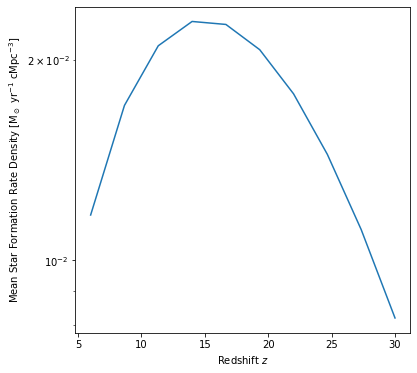

In [41]:
# Plot mean SFRD
fig, ax = plt.subplots(figsize=(6,6))

plotting_zs = np.linspace(6, 30, 10)  # What redshifts to use
test_f_star = 0.01                    # Need a value of fstar

ax.plot(plotting_zs, [np.mean(star_formation_rate_density(z, test_f_star)) for z in plotting_zs])
ax.set_yscale('log')
ax.set_xlabel(r"Redshift $z$")
ax.set_ylabel(r"Mean Star Formation Rate Density [M$_{\rm \odot}$ yr$^{-1}$ cMpc$^{-3}$]")
plt.show()
plt.close(fig)

Note normally we would not expect the star formation rate to peak (at least not until $z \approx 2$). This is an artefact of our oversimplified star formation model, in particular assuming a fixed $f_*$ for all halo masses and not including any feedback effects. 